# **Codenation**
## Desafio - Semana 8 

### __Importando módulos__

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
# Configurações para o Seaborn.
from IPython.core.pylabtools import figsize
sns.set()
figsize(12,8)

### __Carregando os dados__

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Gerando DataFrame de resposta.
answer = pd.DataFrame()

# A coluna 'NU_INSCRICAO' de df_test deve ser salva em answer para gerar o .csv de resposta que o desafio pede.
answer['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

### **Análise / Ajustes** 

In [4]:
print(f'DataFrame: df_train\nLinhas: {df_train.shape[0]} |\tColunas: {df_train.shape[1]}')

DataFrame: df_train
Linhas: 13730 |	Colunas: 167


In [5]:
print(f'DataFrame: df_test\nLinhas: {df_test.shape[0]}  |\tColunas: {df_test.shape[1]}')

DataFrame: df_test
Linhas: 4576  |	Colunas: 47


Obs: O DataFrame `df_teste` aparenta possuir as features ideais já selecionadas.

In [6]:
# Checando se as features de df_teste está contida em df_train.
features_train = df_train.columns.to_list()
features_test = df_test.columns.to_list()

# Se os elementos da lista de features de df_test estiver contido na lista de features de df_train retornará True.
feature_train_contains_test = all(feature in features_train for feature in features_test)

feature_train_contains_test

True

`df_teste possui todas as features contidas em df_train`

Selecionaremos as mesmas features de `df_test` para `df_train`

In [7]:
# Gerando lista de features.
features = df_test.columns.to_list()

# Adicionando o target na lista de features para treino.
features.append('NU_NOTA_MT')

In [8]:
# Criando os dados de treino e teste
train = df_train[features].copy()
test = df_test.copy()

Análisando o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip) há algumas features que representam códigos de inscrições, códigos das provas, que dificilmente agregariam algum valor ou teriam algum impacto positivo em nosso modelo, então serão dropados de `train` e `test`

In [9]:
# Dropando atributos de código que dificilmente acrescentariam em algo ao nosso modelo.
train.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)
test.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)

In [10]:
# Checando se há NaN values nas features categóricas.
train.select_dtypes('object').isnull().sum()

SG_UF_RESIDENCIA       0
TP_SEXO                0
Q001                   0
Q002                   0
Q006                   0
Q024                   0
Q025                   0
Q026                   0
Q027                7373
Q047                   0
dtype: int64

No [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip) o atributo `Q027` corresponde a seguinte pergunta:
- `Com que idade você começou a exercer uma atividade remunerada?`

Entretanto, esse atributo está correlacionado com o atributo `Q026` que pergunta:
- `Você exerce ou já exerceu atividade remunerada?`

Caso o candidato responda com `(A, Nunca Trabalhei)`, então o candidato não responderá a pergunta `Q027`.


Precisamos tratar esses dados faltantes de alguma forma.
Dropar não é a melhor opção pois são muitos dados e a exclusão poderia afetar a performance do modelo no final.

Podemos atribuir uma variável do tipo `categórica` que "represente" um valor NaN (Nulo) para esses valores faltantes.

In [11]:
# Preenchendo os NaN values das features categóricas com '-'
train['Q027'] = train['Q027'].fillna('-')
test['Q027'] = test['Q027'].fillna('-')

In [12]:
# Checando valorer NaN values nas features numéricas
train.select_dtypes({'int', 'float'}).isnull().sum()

TP_ENSINO                 9448
TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_STATUS_REDACAO         3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
NU_NOTA_MT                3597
dtype: int64

Por se tratar do ENEM, se há valores nulos em features numéricas, faz sentido preencher com `0` já que podemos inferir que esse candidato possa:
- Não ter respondido alguma questão.
- Ter sido desqualificado por algum motivo.
- Ter faltado algum dia de prova ou os dois dias.
- Tido algum problema na contabilização das respostas.

Excluir essa quantidade de dados pode prejudicar o desempenho do modelo.

De forma simplificada, atribuíremos o valor `0` as variáveis faltantes:

In [13]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

#### Checando número de linhas e colunas de ambos DataFrames

In [14]:
print(f'Train\nLinhas: {train.shape[0]}\nColunas: {train.shape[1]}')

Train
Linhas: 13730
Colunas: 43


In [15]:
print(f'Test\nLinhas: {test.shape[0]}\nColunas: {test.shape[1]}')

Test
Linhas: 4576
Colunas: 42


`train` possui uma coluna a mais pois contém o target `NU_NOTA_MT` que posteriormente será dropada.

## Plots


array([[<AxesSubplot:title={'center':'NU_NOTA_CH'}>,
        <AxesSubplot:title={'center':'NU_NOTA_CN'}>,
        <AxesSubplot:title={'center':'NU_NOTA_COMP1'}>,
        <AxesSubplot:title={'center':'NU_NOTA_COMP2'}>],
       [<AxesSubplot:title={'center':'NU_NOTA_COMP3'}>,
        <AxesSubplot:title={'center':'NU_NOTA_COMP4'}>,
        <AxesSubplot:title={'center':'NU_NOTA_COMP5'}>,
        <AxesSubplot:title={'center':'NU_NOTA_LC'}>],
       [<AxesSubplot:title={'center':'NU_NOTA_MT'}>,
        <AxesSubplot:title={'center':'NU_NOTA_REDACAO'}>,
        <AxesSubplot:title={'center':'TP_DEPENDENCIA_ADM_ESC'}>,
        <AxesSubplot:title={'center':'TP_ENSINO'}>],
       [<AxesSubplot:title={'center':'TP_STATUS_REDACAO'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

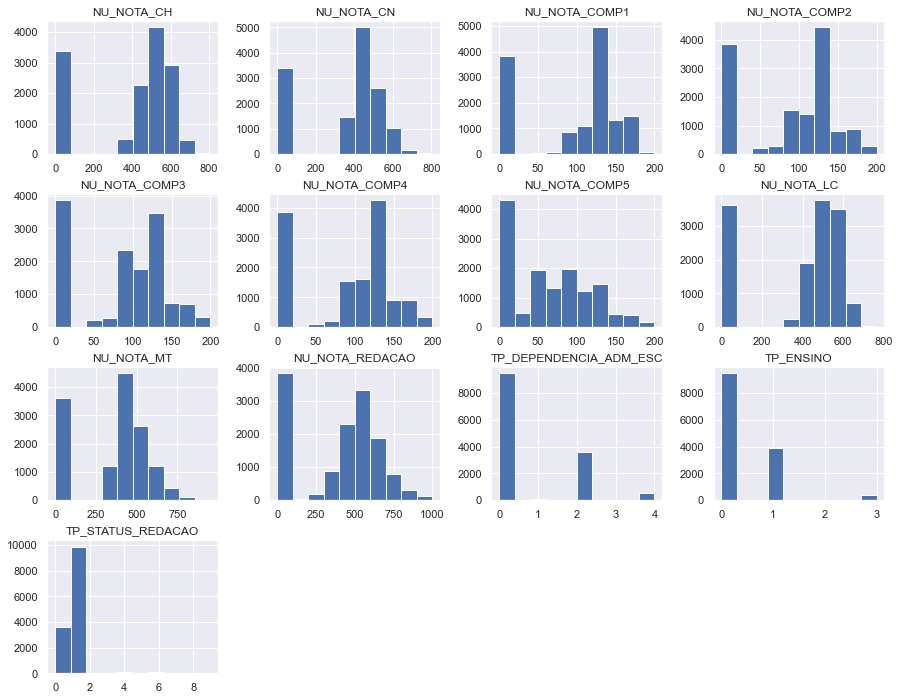

In [16]:
figsize(15,12)

# Visualizando a distribuição das features numéricas
train.select_dtypes({'int','float'}).hist()

<AxesSubplot:>

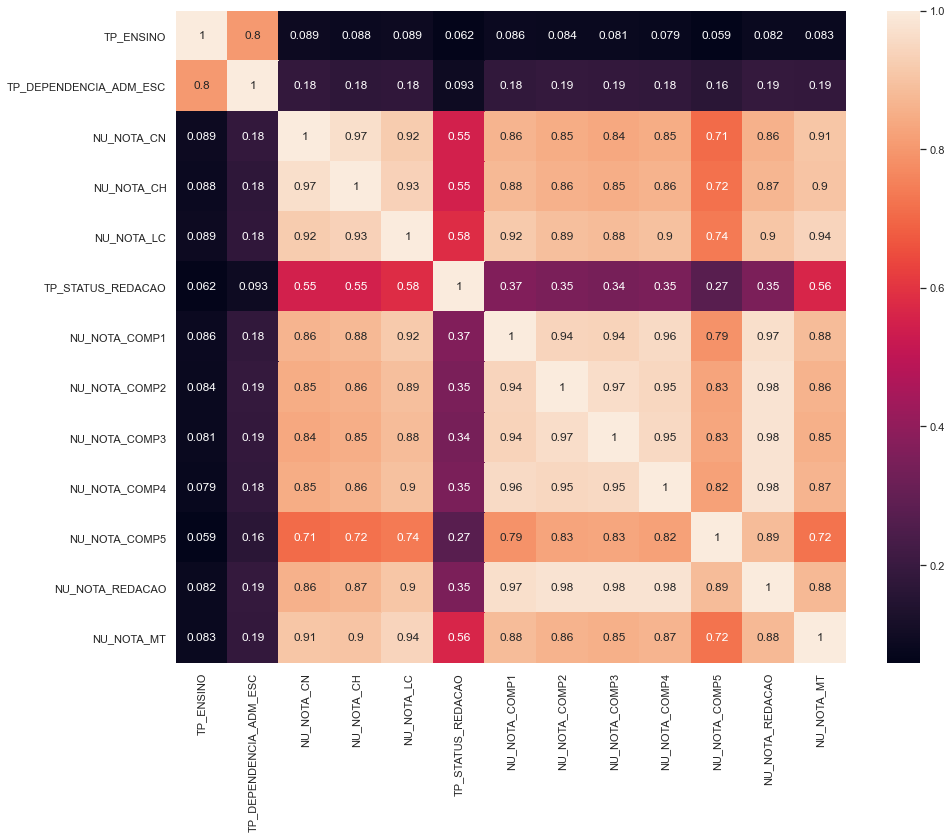

In [17]:
# Checando correlação entre as features numéricas

sns.heatmap(data=train.select_dtypes({'int','float'}).corr(), annot=True)

#### Verificaremos o desempenho do modelo utilizando as features já selecionadas sem excluir ou adicionar mais nenhuma.

### **Selecionando e separando as colunas por tipo**

In [18]:
cat_columns = train.select_dtypes('object').columns
num_columns = train.select_dtypes({'int', 'float'}).columns
cat_columns

Index(['SG_UF_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047'],
      dtype='object')

In [19]:
num_columns = num_columns.drop('NU_NOTA_MT')
num_columns

Index(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'],
      dtype='object')

### **Criando uma instância de** `make_column_transformer`
#### Para aplicar os preprocessadores em tipos distinstos de colunas (numeric, object)
Nesse caso a instância de `make_column_transformer()` irá aplicar o `OneHotEncoder()` nas features categóricas e irá aplicar o `MinMaxScaler()` nas features numéricas.

In [20]:
column_trans = make_column_transformer((OneHotEncoder(), cat_columns),
                                       (MinMaxScaler(), num_columns),
                                        remainder='passthrough')

#### Gerando um Pipeline com o `make_column_tranformer` e `LinearRegression()`

In [21]:
lr_model = LinearRegression()
lr_pipe = make_pipeline(column_trans, lr_model)

#### Separando X_train, y_train

In [22]:
X_train = train.drop(['NU_NOTA_MT'], axis=1)
y_train = train['NU_NOTA_MT']
X_test = test.copy()

# ------ **TESTES** ------

**Por se tratar de um problema de Regressão, iremos avaliar o `RMSE (Root Mean Squared Error / Raiz do Erro Quadrático Médio)`.**

In [23]:
def rmse_score(pipeline, x, y):
    return print(f'RMSE: {cross_val_score(pipeline, x, y, cv=10, scoring="neg_root_mean_squared_error").mean().round(4)}')

#### OneHotEncoder / MinMaxScaler / LinearRegression 

In [24]:
# Resultado
rmse_score(lr_pipe, X_train, y_train)

RMSE: -66.7583


#### OneHotEncoder / MinMaxScaler / RandomForestRegressor

In [25]:
rfr = RandomForestRegressor(n_jobs=-1)
rfr_pipe = make_pipeline(column_trans, rfr)

In [26]:
# Resultado
rmse_score(rfr_pipe, X_train, y_train)

RMSE: -63.0389


#### OneHotEncoder / StandardScaler / RandomForestRegressor

In [27]:
column_trans_std_scaler = make_column_transformer(
                                                (OneHotEncoder(), cat_columns),
                                                (StandardScaler(), num_columns),
                                                 remainder="passthrough"
                                                 )

rf_reg = RandomForestRegressor(n_jobs=-1)
pipe_rf_reg = make_pipeline(column_trans_std_scaler, rf_reg)

In [28]:
# Resultado
rmse_score(pipe_rf_reg, X_train, y_train)

RMSE: -63.2672


#### OneHotEncoder / StandardScaler / LinearRegression

In [29]:
lr_model = LinearRegression()
lr_pipe = make_pipeline(column_trans_std_scaler, lr_model)

In [30]:
# Resultado
rmse_score(lr_pipe, X_train, y_train)

RMSE: -66.7527


#### A melhor combinação que mostrou o menor `RMSE`:
##### **OneHotEncoder / StandardScaler / RandomForestRegressor**

## Testes exaustivos usando o `GridSearchCV()`

Usaremos o GridSearchCV para procurar os melhores parâmetros para otimizar o algoritmo `RandomForestRegressor()`<br>
Treinaremos dois modelos utilizando o `StandardScaler()` e `MinMaxScaler()` devido a pouca diferença no `score` de `RMSE`.

#### **`StandardScaler()`**

In [31]:
# Instanciando um novo make_column_transformer

column_transform_std = make_column_transformer((OneHotEncoder(), cat_columns),
                                       (StandardScaler(), num_columns),
                                        remainder='passthrough')

# Instanciando um novo RandomForestRegressor
rfr = RandomForestRegressor()

# Instanciando um Pipeline com o OneHotEncoder / StandardScaler / RandomForestRegressor
rfr_pipeline_std = Pipeline(steps=[('column_transform_std', column_transform_std),
                               ('rfr', rfr)
                               ]
                       )

In [32]:
# Gerando listas com possíveis valores para os parâmetros de rfr()
val_estimator = [100, 150, 200, 250]
val_criterion = ["mse"]
val_max_features = ["auto", "log2"]

# Criando um dict para passar aos parametros do RandomForest dentro do GridSearchCV
grid_params = dict(
        rfr__n_estimators=val_estimator,
        rfr__criterion=val_criterion,
        rfr__max_features=val_max_features)

# Instânciando o GridSearchCV
grid_std = GridSearchCV(rfr_pipeline_std, grid_params, cv=10, n_jobs=-1)

In [33]:
# Treinando o modelo (Obs.: Esta etapa pode demorar bastante)
grid_std.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('column_transform_std',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         Index(['SG_UF_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047'],
      dtype='object')),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 

In [34]:
# Gerando um DataFrame com os resultados do GridSearchCV
standard_scaler_results = pd.DataFrame(grid_std.cv_results_)
standard_scaler_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfr__criterion,param_rfr__max_features,param_rfr__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,18.234936,0.929222,0.054357,0.010809,mse,auto,100,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.926496,0.927836,...,0.928379,0.917547,0.920463,0.929830,0.927886,0.919907,0.920915,0.923736,0.004514,4
1,26.202702,1.138161,0.074741,0.007366,mse,auto,150,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.926555,0.927701,...,0.928829,0.917117,0.920199,0.930114,0.928293,0.921241,0.920956,0.924065,0.004438,3
2,36.069736,0.259789,0.100636,0.004207,mse,auto,200,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.926568,0.928058,...,0.928997,0.918042,0.920715,0.931134,0.928562,0.920938,0.920968,0.924331,0.004532,1
3,45.897623,0.400799,0.127016,0.011272,mse,auto,250,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.927128,0.928379,...,0.928826,0.917821,0.919548,0.930546,0.928120,0.920561,0.920614,0.924131,0.004595,2
4,2.050107,0.028063,0.060592,0.003583,mse,log2,100,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.918609,0.926150,...,0.924184,0.915563,0.912962,0.927121,0.924289,0.918108,0.919457,0.919692,0.005377,8
5,3.158101,0.029601,0.083433,0.007581,mse,log2,150,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.920252,0.927020,...,0.924092,0.915772,0.912597,0.927093,0.924400,0.917757,0.918474,0.919706,0.005684,7
6,4.172988,0.122193,0.104376,0.005075,mse,log2,200,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.920484,0.927659,...,0.925018,0.915263,0.912031,0.926956,0.924763,0.917495,0.920048,0.920094,0.005696,5
7,5.165771,0.090944,0.133103,0.013248,mse,log2,250,"{'rfr__criterion': 'mse', 'rfr__max_features':...",0.919780,0.927182,...,0.924763,0.914770,0.911397,0.927097,0.924789,0.918815,0.919571,0.919939,0.005723,6


In [35]:
standard_scaler_score = grid_std.best_score_
standard_scaler_score

0.924330571025511

In [36]:
standard_scaler_score.round(4)

0.9243

#### **`MinMaxScaler()`**

In [37]:
# Instanciando um novo make_column_transformer

column_transform_min_max = make_column_transformer((OneHotEncoder(), cat_columns),
                                       (MinMaxScaler(), num_columns),
                                        remainder='passthrough')

# Instanciando um novo RandomForestRegressor
rfr = RandomForestRegressor()

# Instanciando um Pipeline com o OneHotEncoder / StandardScaler / RandomForestRegressor
rfr_pipeline = Pipeline(steps=[('column_transform_min_max', column_transform_min_max),
                               ('rfr', rfr)
                               ]
                       )

In [38]:
# Gerando listas com possíveis valores para os parâmetros de rfr()
val_estimator = [100, 150, 200, 250]
val_criterion = ["mse"]
val_max_features = ["auto", "log2"]

# Criando um dict para passar aos parametros do RandomForest dentro do GridSearchCV
grid_params = dict(
        rfr__n_estimators=val_estimator,
        rfr__criterion=val_criterion,
        rfr__max_features=val_max_features)

# Instânciando o GridSearchCV
grid_min_max = GridSearchCV(rfr_pipeline, grid_params, cv=10, n_jobs=-1)

In [39]:
grid_min_max.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('column_transform_min_max',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         Index(['SG_UF_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047'],
      dtype='object')),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         Index(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 

In [40]:
min_max_score = grid_min_max.best_score_
min_max_score

0.9243912202988132

In [41]:
min_max_score.round(4)

0.9244

A diferença ainda é mínima mesmo trocando os preprocessadores de dados, usaremos o modelo treinado com o `MinMaxScaler()` para prever as notas de `"NU_NOTA_MT"`

In [42]:
pred = pd.Series(grid_min_max.predict(X_test))

<AxesSubplot:>

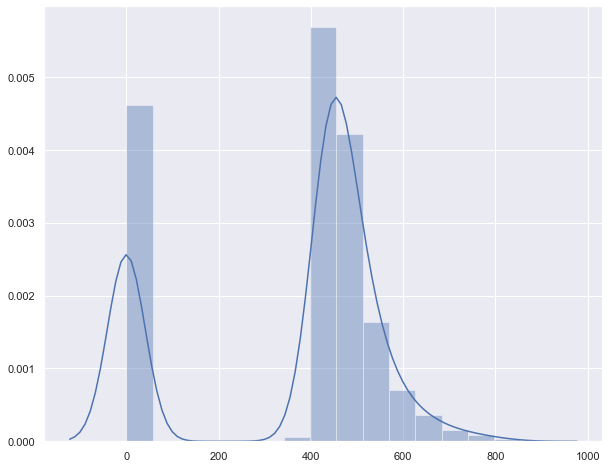

In [43]:
figsize(10,8)
sns.distplot(pred)

In [44]:
# Checando se há valores a baixo de 0 ou acima de 1000.0
# Se houverem valores abaixo de 0, deve ser feito uma correção de arredondamento desses valores pra 0.

pred.min(), pred.max()

(0.0, 854.2908000000012)

In [45]:
answer['NU_NOTA_MT'] = pred.round(2)

In [46]:
answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,427.78
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,440.38
2,b38a03232f43b11c9d0788abaf060f7366053b6d,584.65
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.00
4,715494628a50142ce8cb17191cfe6d0f3cae0934,539.87
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,452.96
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,478.07
4573,655fa6306720ff16e825903b5422a46608a77545,682.83
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,459.83


In [47]:
answer.to_csv('answer.csv', index=False, header=True)

`Resultado do submit do desafio:`

![title](result_score.png)